Enter the number of stocks for the efficient frontier model: 2
Add stock 1: amzn
Add stock 2: wmt
You have added the following stocks: ['AMZN', 'WMT']


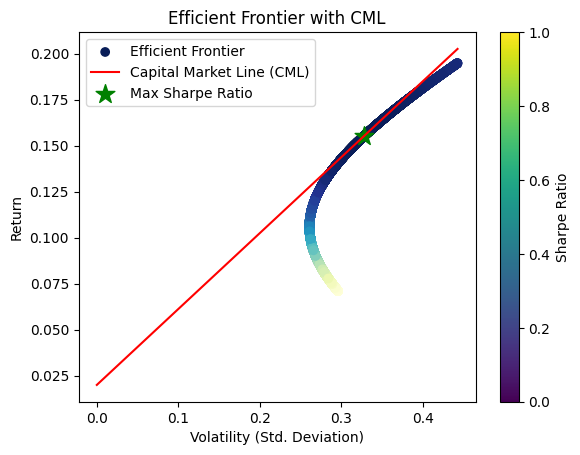


Optimal Portfolio Weights:
AMZN: 67.84%
WMT: 32.16%

Expected Annual Return: 15.50%
Annual Volatility (Risk): 32.73%
Sharpe Ratio: 0.47


In [1]:
import pandas as pd
import requests
import numpy as np
import matplotlib.pyplot as plt

# --------------------- Model ---------------------

class StockModel:
    def __init__(self, api_key):
        self.api_key = api_key  # Store the API key passed in
        self.api_base_url = "https://www.alphavantage.co/query"  # Store the full base URL

    def get_historical_prices(self, ticker):
        # Set the parameters
        parameters = {
            "function": "TIME_SERIES_DAILY",  # Function to retrieve DAILY data
            "symbol": ticker,                 # Stock ticker symbol
            "apikey": self.api_key,           # API key for authentication
            "outputsize": "full"              # Retrieve full history (255+ days)
        }

        # Send request to Alpha Vantage API
        response = requests.get(self.api_base_url, params=parameters)

        # Handle the response
        if response.status_code == 200:
            data = response.json()  # Convert response data to JSON
            try:
                # Get the daily time series data
                daily_data = data['Time Series (Daily)']
                # Extract dates and closing prices into a pandas DataFrame
                dates = []
                closing_prices = []

                # Loop through the dates and retrieve the closing prices
                for date in daily_data.keys():
                    dates.append(date)
                    closing_prices.append(float(daily_data[date]['4. close']))

                # Convert the lists into a pandas DataFrame
                df = pd.DataFrame({'Date': dates, 'Close': closing_prices})
                df['Date'] = pd.to_datetime(df['Date'])  # Convert the Date to datetime format
                df = df.sort_values(by='Date', ascending=True)  # Sort by date (oldest first)

                # Return the last 2550 days of data
                return df.tail(2550)
            except KeyError:
                return None
        else:
            return None

    def calculate_daily_returns(self, df):
        """
        This function calculates daily returns for a given DataFrame of stock prices.
        The DataFrame should have a 'Close' column representing closing prices.
        """
        df['Daily Return'] = df['Close'].pct_change()  # Calculate percentage change between consecutive days
        df = df.dropna()  # Drop the first row with NaN
        return df

    def calculate_efficient_frontier(self, stock_data, risk_free_rate=0.02):
        returns = pd.concat([data['Daily Return'] for data in stock_data], axis=1)
        returns.columns = [f'Stock {i+1}' for i in range(len(stock_data))]  # Naming the columns

        # Calculate mean returns and covariance matrix
        mean_returns = returns.mean() * 252  # Annualized return
        cov_matrix = returns.cov() * 252  # Annualized covariance

        num_portfolios = 10000
        results = np.zeros((4, num_portfolios))
        weights_record = []

        for i in range(num_portfolios):
            weights = np.random.random(len(stock_data))
            weights /= np.sum(weights)
            weights_record.append(weights)

            portfolio_return = np.dot(weights, mean_returns)
            portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
            sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_std_dev

            results[0,i] = portfolio_return
            results[1,i] = portfolio_std_dev
            results[2,i] = sharpe_ratio
            results[3,i] = i  # Store portfolio index for identification

        # Find the portfolio with the highest Sharpe ratio (optimal portfolio)
        max_sharpe_idx = np.argmax(results[2])
        max_sharpe_return = results[0, max_sharpe_idx]
        max_sharpe_volatility = results[1, max_sharpe_idx]
        optimal_weights = weights_record[max_sharpe_idx]

        return results, max_sharpe_return, max_sharpe_volatility, optimal_weights, mean_returns, cov_matrix


# --------------------- View ---------------------

class StockView:
    def display_portfolio_info(self, optimal_weights, stock_list, max_sharpe_return, max_sharpe_volatility):
        """
        Display key portfolio information such as weights, returns, volatility, etc.
        """
        print("\nOptimal Portfolio Weights:")
        for i, stock in enumerate(stock_list):
            print(f"{stock}: {optimal_weights[i]:.2%}")

        print(f"\nExpected Annual Return: {max_sharpe_return:.2%}")
        print(f"Annual Volatility (Risk): {max_sharpe_volatility:.2%}")
        print(f"Sharpe Ratio: {(max_sharpe_return / max_sharpe_volatility):.2f}")

    def plot_efficient_frontier_with_cml(self, results, risk_free_rate, max_sharpe_return, max_sharpe_volatility):
        """
        Plot the efficient frontier along with the Capital Market Line (CML).
        """
        # Plot Efficient Frontier
        plt.scatter(results[1,:], results[0,:], c=results[2,:], cmap='YlGnBu', marker='o', label="Efficient Frontier")

        # Plot the Capital Market Line (CML)
        cml_x = np.linspace(0, max(results[1,:]), 100)
        cml_y = risk_free_rate + (max_sharpe_return - risk_free_rate) / max_sharpe_volatility * cml_x
        plt.plot(cml_x, cml_y, color='red', label='Capital Market Line (CML)')

        # Highlight the max Sharpe ratio portfolio
        plt.scatter(max_sharpe_volatility, max_sharpe_return, color='green', marker='*', s=200, label="Max Sharpe Ratio")

        # Set titles and labels
        plt.title('Efficient Frontier with CML')
        plt.xlabel('Volatility (Std. Deviation)')
        plt.ylabel('Return')
        plt.colorbar(label='Sharpe Ratio')
        plt.legend()
        plt.show()


# --------------------- Controller ---------------------

class StockController:
    def __init__(self, model, view):
        self.model = model
        self.view = view

    def run(self):
        # Get user input for the number of stocks for the efficient frontier model
        while True:
            try:
                stock_number = int(input("Enter the number of stocks for the efficient frontier model: "))
                break  # Exit the loop if input is valid
            except ValueError:
                print("Invalid input. Please enter a valid number.")

        # Initialize an empty list to store the stock tickers
        stock_list = []

        # Loop to ask for stock tickers 'stock_number' times
        for i in range(stock_number):
            ticker_input = input(f"Add stock {i+1}: ").upper()  # Request stock ticker
            stock_list.append(ticker_input)  # Add the ticker to the list

        # Display the collected stock tickers
        print(f"You have added the following stocks: {stock_list}")

        # Fetch and store historical prices for each stock
        stock_data = []
        for ticker in stock_list:
            historical_prices = self.model.get_historical_prices(ticker)
            if historical_prices is not None:
                # Calculate daily returns and store the DataFrame
                historical_prices_with_returns = self.model.calculate_daily_returns(historical_prices)
                stock_data.append(historical_prices_with_returns)
            else:
                print(f"Error fetching data for {ticker}.")

        # Ensure we have data for all stocks
        if len(stock_data) == stock_number:
            # Set risk-free rate for CML
            risk_free_rate = 0.02

            # Calculate the Efficient Frontier and retrieve key info
            results, max_sharpe_return, max_sharpe_volatility, optimal_weights, mean_returns, cov_matrix = self.model.calculate_efficient_frontier(stock_data, risk_free_rate)

            # Plot the Efficient Frontier with CML
            self.view.plot_efficient_frontier_with_cml(results, risk_free_rate, max_sharpe_return, max_sharpe_volatility)

            # Display portfolio key information
            self.view.display_portfolio_info(optimal_weights, stock_list, max_sharpe_return, max_sharpe_volatility)
        else:
            print("Error: Could not fetch data for all stocks.")


# --------------------- Main ---------------------

if __name__ == '__main__':
    # API Key (replace this with your Alpha Vantage API key)
    api_key = 'DV1CKZXU9ORDJ3EV'

    # Initialize model, view, and controller
    model = StockModel(api_key)
    view = StockView()
    controller = StockController(model, view)

    # Run the application
    controller.run()
